In [7]:
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

In [ ]:
combined = pd.read_csv('Dataset.csv')

rows_to_drop = combined.loc[combined['Patient_ID'].apply(lambda x: len(str(x)) == 6)]
df_train = combined.drop(rows_to_drop.index)
df_train.to_csv('data_part1.csv', index=False)

rows_to_drop = combined.loc[combined['Patient_ID'].apply(lambda x: len(str(x)) != 6)]
df_test = combined.drop(rows_to_drop.index)
df_test.to_csv('data_part2.csv', index=False)

In [ ]:
df_train = pd.read_csv('data_part1.csv')
df_test = pd.read_csv('data_part2.csv')

In [ ]:
df_train.head()

In [ ]:
df_train.columns

In [ ]:
patients = list(df_test['Patient_ID'].unique())
len(patients)

In [ ]:
def corr_matrix(df):
  corr = df.corr()
  mask = np.triu(np.ones_like(corr, dtype=bool))
  f, ax = plt.subplots(figsize=(40,40))
  cmap = sns.diverging_palette(220, 10, as_cmap=True)
  sns.heatmap(corr, mask=mask, cmap="Paired", vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
null_values = df_train.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

In [ ]:
columns_drop={'Unnamed: 0','SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium', 
'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2'}
df_train = df_train.assign(Unit=df_train['Unit1'] + df_train['Unit2'])
df_train_mod = df_train.drop(columns=columns_drop)
df_train_mod.columns

In [ ]:
corr_matrix(df_train_mod)

In [ ]:
df_train_impute = df_train_mod.copy()
columns_impute = list(df_train_impute.columns)

In [ ]:
grouped_by_patient = df_train_impute.groupby('Patient_ID')
df_train_impute = grouped_by_patient.apply(lambda x: x.bfill().ffill())

In [ ]:
df_train_impute.head()

In [ ]:
null_values = df_train_impute.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

In [ ]:
null_col = ['TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2',
            'Unit', 'Patient_ID']
df_train_impute = df_train_impute.drop(columns=null_col)
df_train_impute.columns

In [ ]:
one_hot = pd.get_dummies(df_train_impute['Gender'])
df_train_impute = df_train_impute.join(one_hot)
df_train_impute = df_train_impute.drop('Gender', axis=1)

In [ ]:
def diagnostic_plots(df, variable):
    fig = plt.figure(figsize=(15,4))
    ax = fig.add_subplot(121)
    df[variable].hist(bins=30)
    ax = fig.add_subplot(122)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.xlabel(variable)
    plt.show()

In [ ]:
def try_gaussian(df, col):
  print('actual plot')
  diagnostic_plots(df,col)
  # this applies yeojohnson plot
  df['col_yj'], param = stats.yeojohnson(df[col]) 
  print('yeojohnson plot')
  diagnostic_plots(df, 'col_yj')
  # this applies exponential transformation
  df['col_1.5'] = df[col]**(1/1.5)
  print('**1/1.5 plot') 
  diagnostic_plots(df, 'col_1.5')
  df['col_.5'] = df[col]**(.5)
  print('**.5 plot') 
  # this applies inverse transformation
  diagnostic_plots(df, 'col_.5')
  df['col_rec'] = 1 / (df[col]+0.00001) 
  diagnostic_plots(df, 'col_rec')
  # this applies logarithmic trasnformation
  df['col_log'] = np.log(df[col]+1)
  diagnostic_plots(df, 'col_log') 

In [ ]:
lst = ['O2Sat', 'Temp', 'MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
for i in lst:
  print(i)
  try_gaussian(df_train_impute, i)

In [ ]:
df_train_impute = df_train_impute.drop(columns = ['col_yj','col_1.5','col_.5','col_rec','col_log'])

In [ ]:
df_train_impute.head()

In [ ]:
columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
for i in columns_normalized:
  df_train_impute[i] = np.log(df_train_impute[i]+1)

In [ ]:
df_train_impute.head()

In [ ]:
scaler = StandardScaler()
df_train_impute[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']] = scaler.fit_transform(df_train_impute[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']])
df_train_impute.head()

In [ ]:
df_train_impute = df_train_impute.dropna()
null_values = df_train_impute.isnull().mean()*100
null_values


In [ ]:
def get_data_ready(df):
  columns_drop={'Unnamed: 0','SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium', 
  'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2'}
  df = df.assign(Unit=df['Unit1'] + df['Unit2'])
  # dropping columns based on redundancy
  df = df.drop(columns=columns_drop)
  grouped_by_patient = df.groupby('Patient_ID')
  # imputing backfill and forward fill
  df = grouped_by_patient.apply(lambda x: x.bfill().ffill())
  # dropping all the columns with null values more than 25% and patient_id
  null_col = ['TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2','Unit', 'Patient_ID']
  df = df.drop(columns=null_col)
  # gaussian transformation
  columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
  for i in columns_normalized:
    df[i] = np.log(df[i]+1)
  # normailizing
  scaler = StandardScaler()
  df[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']] = scaler.fit_transform(df[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']])
  # onehot encoding the gender
  one_hot = pd.get_dummies(df['Gender'])
  df = df.join(one_hot)
  df = df.drop('Gender', axis=1)
  df = df.dropna()
  return df

In [ ]:
def evaluate_model(y_true,y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  print("Accuracy:", accuracy)
  precision = precision_score(y_true, y_pred)
  print("Precision:", precision)
  recall = recall_score(y_true, y_pred)
  print("Recall:", recall)
  f1 = f1_score(y_true, y_pred)
  print("F1 Score:", f1)
  auc = roc_auc_score(y_true, y_pred)
  print("AUC-ROC:", auc)
  mae = mean_absolute_error(y_true, y_pred)
  print("Mean Absolute Error:", mae)
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  print("Root Mean Squared Error:", rmse)
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, fmt='d')
  plt.show()

In [ ]:

majority_class = df_train_impute[df_train_impute['SepsisLabel'] == 0]
minority_class = df_train_impute[df_train_impute['SepsisLabel'] == 1]
print('number of sepsis label 1 is {}'.format(len(minority_class)))
print('while number of sepsis label 0 is {}'.format(len(majority_class)))

In [ ]:
majority_class_subset = majority_class.sample(n=2*len(minority_class))
df_train_impute = pd.concat([majority_class_subset, minority_class])

In [ ]:
corr_matrix(df_train_impute)


In [ ]:
X = df_train_impute.drop('SepsisLabel', axis=1)
y = df_train_impute['SepsisLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [55]:
model = RandomForestClassifier(n_estimators=200, random_state=0)
model.fit(X_train, y_train)
rcf_predictions = model.predict(X_test)
print(rcf_predictions)

[0 0 0 ... 0 0 1]


Accuracy: 0.9591102387962054
Precision: 0.9233196591984854
Recall: 0.9568345323741008
F1 Score: 0.9397783844547937
AUC-ROC: 0.9585415913956223
Mean Absolute Error: 0.04088976120379457
Root Mean Squared Error: 0.20221216878267878


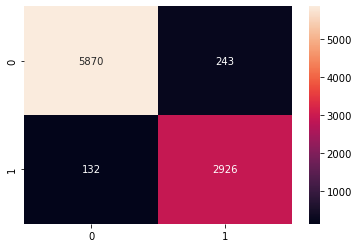

In [56]:
evaluate_model(y_test,rcf_predictions)

Accuracy: 0.7511721731545088
Precision: 0.706163655685441
Recall: 0.434597776324395
F1 Score: 0.5380566801619433
AUC-ROC: 0.6720674142541327
Mean Absolute Error: 0.24882782684549123
Root Mean Squared Error: 0.4988264496250086


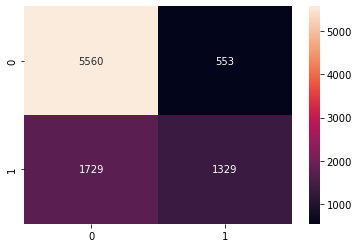

In [41]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
nbc_predictions = model.predict(X_test)
evaluate_model(y_test,nbc_predictions)

Accuracy: 0.8248827826845492
Precision: 0.7682926829268293
Recall: 0.6798561151079137
F1 Score: 0.7213740458015268
AUC-ROC: 0.7886439090180498
Mean Absolute Error: 0.17511721731545088
Root Mean Squared Error: 0.41847009130337004


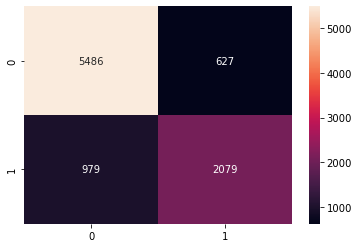

In [42]:
from sklearn.neighbors import KNeighborsClassifier
# model = KNeighborsClassifier(n_neighbors=8)
# model = KNeighborsClassifier(n_neighbors=5)
model = KNeighborsClassifier(n_neighbors=10)
model.fit(X_train, y_train)
knn_predictions = model.predict(X_test)
evaluate_model(y_test,knn_predictions)

C:\Users\Prathiksha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7511721731545088
Precision: 0.7368742368742369
Recall: 0.394702419882276
F1 Score: 0.5140545144804088
AUC-ROC: 0.6620984698789754
Mean Absolute Error: 0.24882782684549123
Root Mean Squared Error: 0.4988264496250086


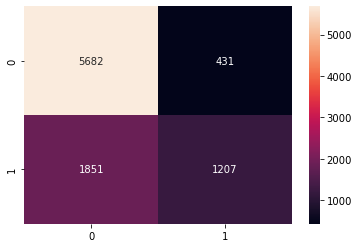

In [43]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
lr_predictions = model.predict(X_test)
evaluate_model(y_test,lr_predictions)

Accuracy: 0.8650092683458729
Precision: 0.7750906892382105
Recall: 0.8384565075212557
F1 Score: 0.8055293748036444
AUC-ROC: 0.8583743358806999
Mean Absolute Error: 0.13499073165412714
Root Mean Squared Error: 0.36741084857979783


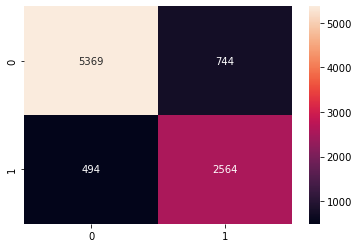

In [44]:
nn = MLPClassifier(max_iter=5000, hidden_layer_sizes=(50,50,50,50), verbose=0, learning_rate="adaptive")
nn.fit(X_train, y_train)
mlp=nn.predict(X_test)
evaluate_model(y_test,mlp)

[14:45:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

Accuracy: 0.8643550321666121
Precision: 0.8356772760917839
Recall: 0.7383911052975801
F1 Score: 0.7840277777777777
AUC-ROC: 0.8328795048817362
Mean Absolute Error: 0.13564496783338786
Root Mean Squared Error: 0.36830010566572996


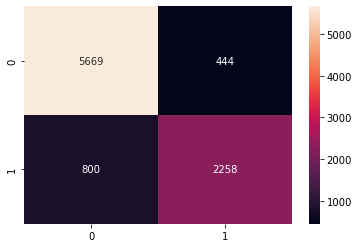

In [45]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
param = {
    'max_depth': 5,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'binary:logistic'}  # error evaluation for binary classification
num_round = 100
bst = xgb.train(param, dtrain, num_round)
xgb_predictions = bst.predict(dtest)
prediction = []
for i in xgb_predictions:
  if i<0.5:
    prediction.append(0)
  else:
    prediction.append(1)
evaluate_model(y_test,prediction)

Accuracy: 0.8346185419946976
Precision: 0.08353491372359297
Recall: 0.5288412455334355
F1 Score: 0.1442796462641877
AUC-ROC: 0.6858697298602103
Mean Absolute Error: 0.16538145800530232
Root Mean Squared Error: 0.4066711915114007


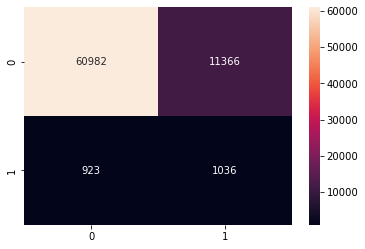

In [46]:
df = get_data_ready(df_test)
X = df.drop('SepsisLabel', axis=1)
y = df['SepsisLabel']
rcf_predictions = model.predict(X)
evaluate_model(y,rcf_predictions)

In [60]:
predictions=[rcf_predictions, knn_predictions, lr_predictions , nbc_predictions]


In [61]:
accuracy_model1 = accuracy_score(y_test, rcf_predictions)
accuracy_model2 = accuracy_score(y_test, knn_predictions)
accuracy_model3 = accuracy_score(y_test, lr_predictions)
accuracy_model4 = accuracy_score(y_test, nbc_predictions)


total_accuracy = accuracy_model1 + accuracy_model2 + accuracy_model3 + accuracy_model4
weight_model1 = accuracy_model1 / total_accuracy
weight_model2 = accuracy_model2 / total_accuracy
weight_model3 = accuracy_model3 / total_accuracy
weight_model4 = accuracy_model4 / total_accuracy

# Create a list of weights
weights = [weight_model1, weight_model2, weight_model3, weight_model4]

In [62]:
ensemble_prediction = np.mean(predictions, axis=0)

In [63]:
weighted_prediction = np.average(predictions, axis=0, weights=weights)

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Assuming 'predictions' is a list of predictions from different models
# 'y_true' is the true labels corresponding to the predictions

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(np.array(predictions).T, y_test, test_size=0.2, random_state=42)

# Initialize meta-model (e.g., linear regression)
meta_model = LinearRegression()

# Train meta-model on predictions
meta_model.fit(X_train, y_train)

# Make predictions using meta-model
ensemble_prediction = meta_model.predict(X_test)



In [65]:
threshold = 0.5

# Convert continuous predictions to binary class labels
binary_predictions = (ensemble_prediction > threshold).astype(int)

# Now, you can compute the accuracy score using the binary predictions
accuracy = accuracy_score(y_test, binary_predictions)
accuracy

0.9596730245231607

In [66]:
precision = precision_score(y_test, binary_predictions)
precision

0.9176090468497576

In [67]:
recall = recall_score(y_test,binary_predictions)
recall

0.961082910321489

In [68]:
f1 = f1_score(y_test,binary_predictions)
f1

0.9388429752066115

In [69]:
roc_auc = roc_auc_score(y_test,binary_predictions)
roc_auc

0.9600430628777864

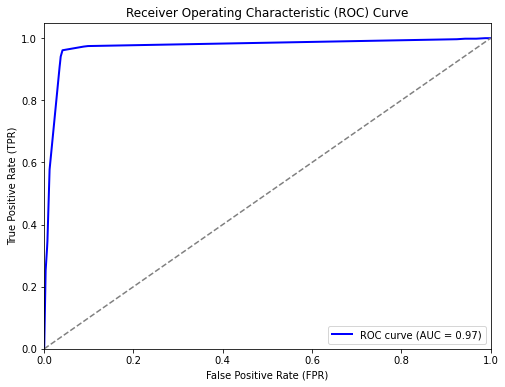

In [70]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


y_score = ensemble_prediction

# Compute false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC)
roc_auc = roc_auc_score(y_test, y_score)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
